<a href="https://colab.research.google.com/github/tzlilLV97/Deep-Learning-Final-Project/blob/main/Copy_of_V1_4_with_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final Project: 

Deep learning Course

Tzlil Lev or 318646510

Alon Feldman - too old to have id number

Project Name : Predict League of Legends victory 







In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive
drive.mount('/content/gdrive')

# Path to save the dataset.
PATH_TO_DATA = '/content/gdrive/MyDrive/Colab Notebooks/DNNPROJECT/games.csv' 

Mounted at /content/gdrive


Data Preperation 


In [2]:
def data_preparation(df_first):
    df = df_first.iloc[:, [2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 20, 23, 26, 27, 28, 29, 30, 36, 39, 42, 45, 48,  51, 52, 53, 54, 55]]
    ## add 2, 5
    ## NORMALIZE THE GAME DURATION
    #df['gameDuration'] = df['gameDuration'].apply(lambda x: np.log(x))
    df = df.drop(df[df.gameDuration<240].index, axis=0)

    labels = df_first.iloc[:, 4].to_numpy() - 1
    #Make it one hot
    labels = [np.eye(2)[label] for label in labels]
    df = df.to_numpy()
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    df = df[indices]
    labels = np.array(labels)[indices]
    return df, labels


def get_batch(data,labels, start, end):
    try:
      x = data[start:end]
      s = labels[start:end]
      return x, s
    except:
      x = data[start:]
      s = labels[start:]
      return x,s


df = pd.read_csv(PATH_TO_DATA)
data, labels = data_preparation(df)
n = len(data)
len_train = int(0.8 * n)
len_test = (n-int(len_train))//2
len_val = len_test
train, valid, test = (data[:len_train],labels[:len_train]), (data[len_train:len_train+len_test],labels[len_train:len_train+len_test]), (data[len_train+len_test:],labels[len_train+len_test:])




In [3]:
def data_preparation(df_first):
    # copy only the feature we decide to use (whitout the label!)
    df_first = df_first.drop(df_first[df_first.gameDuration<240].index, axis=0)
    df = df_first.iloc[:, [2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 20, 23, 26, 27, 28, 29, 30, 36, 39, 42, 45, 48,  51, 52, 53, 54, 55]]
    # drop the outlier in gameDuration and normalzie
    #df['gameDuration'] = df['gameDuration'].apply(lambda x: np.log(x))
    # label vector - we want it to be '0' or '1' and not '1' or '2' (the winning team)
    labels = df_first.iloc[:, 4].to_numpy() - 1
    labels = [np.eye(2)[label] for label in labels]
    df = df.to_numpy()
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    df = df[indices]
    labels = np.array(labels)[indices]
    return df, labels

def get_train_val_test(data,labels):
  n=len(data)
  #seperate test,validation and training set
  len_train = int(0.8 * n)
  len_test = (n-int(len_train))//2
  len_val = len_test
  train, val, test = (data[:len_train],labels[:len_train]), \
      (data[len_train:len_train+len_test],labels[len_train:len_train+len_test]),\
      (data[len_train+len_test:],labels[len_train+len_test:])
  return train, val, test

def get_batch(data,labels, start, end):
    try:
      x = data[start:end]
      s = labels[start:end]
      return x, s
    except:
      x = data[start:]
      s = labels[start:]
      return x,s

df = pd.read_csv(PATH_TO_DATA)
print(df.shape)
data, labels = data_preparation(df)
print(data.shape)
train, valid, test = get_train_val_test(data,labels)


(51490, 61)
(50295, 27)


**BENCHMARK**

In order to evalute our model, we compared it to different models, to 

observe the results and compare them to our network. 

We choose the following models:


* XGBoost

* Random Forest

* KNN

* SVM

* Random Forest

The Following Code is the implementation of each of them


In [4]:
### SVM 

def estimate_accuracy_svm(model, data, labels, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, len(data), batch_size):
        # get a batch of data
        xt, st = get_batch(data, labels, i, i + batch_size)
        # forward pass prediction
        y = model.predict(xt)
        pred = np.squeeze(y)
        correct += np.sum(pred==st)
        N += len(st)

        if N > max_N:
            break
    return correct / N



def svmModel(train, valid, test):
    x_train, y_train = train
    x_valid, y_valid = valid
    x_test, y_test = test
    y_train = np.argmax(y_train, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    y_test = np.argmax(y_test, axis=1)
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    y_pred = svm_model.predict(x_test)
    print("SVM Accuracy on validation set: {:.2f}%".format(estimate_accuracy_svm(svm_model, x_valid, y_valid) * 100))
    print("SVM Accuracy on test set: {:.2f}%".format(estimate_accuracy_svm(svm_model, x_test, y_test) * 100))


svmModel(train, valid, test)
         



SVM Accuracy on validation set: 85.84%
SVM Accuracy on test set: 84.91%


In [5]:
### KNN
def estimate_accuracy_KNN(model, data, labels, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """

    correct = 0
    N = 0
    for i in range(0, len(data), batch_size):
        # get a batch of data
        xt, st = get_batch(data, labels, i, i + batch_size)
        # forward pass prediction
        y = model.predict(xt)
        pred = np.squeeze(y)
        correct += np.sum(pred==st)
        N += len(st)
        if N > max_N:
            break
    return correct / N

def KNN(train,valid,test):
    x_train, y_train = train
    x_valid, y_valid = valid
    x_test, y_test = test
    y_train = np.argmax(y_train, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    y_test = np.argmax(y_test, axis=1)
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("KNN Accuracy on validation set: {:.2f}%".format(estimate_accuracy_KNN(model, x_valid, y_valid) * 100))
    print("KNN Accuracy on test set: {:.2f}%".format(estimate_accuracy_KNN(model, x_test, y_test) * 100))

KNN(train, valid, test)

KNN Accuracy on validation set: 51.02%
KNN Accuracy on test set: 51.47%


In [6]:
### XGBoost

def compare_xgb_predictions(xgb_model, X, y):
    # Make predictions using the trained model
    #global n, y_test,x_test,x_valid,y_valid
    xgb_predictions = xgb_model.predict(X)

    # Round the predictions to 0 or 1
    xgb_predictions = [round(pred) for pred in xgb_predictions]

    # Compare the predictions with the real labels
    correct = 0
    total = len(X)
    for pred, label in zip(xgb_predictions, y):
        if pred == label:
            correct += 1
    # Calculate the accuracy of the predictions
    accuracy = correct / total
    return accuracy



  
def xgb_classifier(train,valid,test):
    #global n, y_test,x_test,x_valid,y_valid
    x_train, y_train = train
    x_valid, y_valid = valid
    x_test, y_test = test
    y_train = np.argmax(y_train, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    y_test = np.argmax(y_test, axis=1)
    #  Write your code here
    model = xgb.XGBClassifier()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
  #  print(classification_report(y_test, y_pred))
    print("XGB Accuracy on validation set: {:.2f}%".format(compare_xgb_predictions(model, x_valid, y_valid) * 100))
    print("XGB Accuracy on test set: {:.2f}%".format(compare_xgb_predictions(model, x_test, y_test) * 100))
          #"compare_xgb_predictions(model, x_test, y_test))

xgb_classifier(train, valid, test)

XGB Accuracy on validation set: 98.15%
XGB Accuracy on test set: 97.89%


Random Forest

In [7]:
def random_forest(train_data, validation_data, test_data):
    # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0)

    # Train the classifier
    clf.fit(train_data[0], train_data[1])

    # Predict the labels of the test set
    preds = clf.predict(validation_data[0])

    # Compute the accuracy: accuracy
    accuracy = accuracy_score(np.argmax(validation_data[1], axis=1), preds)
    print("Random Forest Accuracy on Validation Set: %.2f%%" % (accuracy * 100))
    print("Random Forest Accuracy on Training Set: %.2f%%" % (accuracy_score(np.argmax(train_data[1], axis=1), clf.predict(train_data[0])) * 100))
    print("Random Forest Accuracy on Test Set: %.2f%%" % (accuracy_score(np.argmax(test_data[1], axis=1), clf.predict(test_data[0])) * 100))

def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

random_forest(train, valid, test)

<ipython-input-7-66e3a886dd3b>:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(y_true == y_pred) / len(y_true)


Random Forest Accuracy on Validation Set: 0.00%
Random Forest Accuracy on Training Set: 0.00%
Random Forest Accuracy on Test Set: 0.00%


<ipython-input-7-66e3a886dd3b>:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(y_true == y_pred) / len(y_true)
<ipython-input-7-66e3a886dd3b>:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(y_true == y_pred) / len(y_true)


Accuracy estimation 

In [8]:
def estimate_accuracy_torch(model, data, labels, batch_size=5000, max_N=100000):
  """
  Estimate the accuracy of the model on the data. To reduce
  computation time, use at most `max_N` elements of `data` to
  produce the estimate.
  """

  correct = 0
  N = 0
  for i in range(0, len(data), batch_size):
      # get a batch of data
      xt, st = get_batch(data, labels, i, i + batch_size)
      # forward pass prediction
      y = model(torch.Tensor(xt))
      y = y.detach().numpy()  # convert the PyTorch tensor => numpy array
      y = np.where(y > 0.5, 1, 0)
      pred = np.squeeze(y)
      correct += np.sum(pred==st)
      N += len(st)

      if N > max_N:
          break
  return correct / N




  

Neural Network

In [9]:
class PyTorchMLP2(nn.Module):
    def _init_(self, num_hidden=5):
        super(PyTorchMLP, self)._init_()
        self.input_size = 27  # input_size
        self.hidden_size = 50 # hidden_size was 50
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc5 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc6 = torch.nn.Linear(self.hidden_size, 1)
       # self.dropout = torch.nn.Dropout(0.1)
       # self.optimizer2 = torch.optim.RMSprop(self.parameters())
       #  self.sigmoid = F.sigmoid()
       #  self.tanh = F.tanh()
        self.normalizer = torch.nn.GroupNorm(1, self.hidden_size)
    def forward(self, inp):
        hidden1 = self.fc1(inp)
        relu1 = F.relu(hidden1)
  #      bypass = self.fc6(relu1)
        hidden2 = self.fc2(relu1)
        # Add bypass branch
        bypass = self.fc6(hidden1)
        relu3 = F.sigmoid(hidden2)
        output = self.fc6(relu3)
        output = F.sigmoid(output)
        return output
    # def forward(self, inp):
    #     hidden1 = self.fc1(inp)
    #     relu1 = self.relu(hidden1)
    #     ##ADD BYPASS BRANCH
    #     bypass = self.fc6(relu1)
    #     hidden2 = self.fc2(relu1)
    #     relu2 = self.relu(hidden2)
    #     hidden3 = self.fc3(relu2)
    #     relu3 = self.relu(hidden3)
    #     output = self.fc6(relu3)
    #     ##COMBINE BYPASS AND REGULAR OUTPUTS
    #     return self.sigmoid(output+bypass)


Plotting Function

In [10]:
 
def plot_learning_curve(model_data,cost_label=False):
  """
  Plot the learning curve.
  """
  iters, losses, iters_sub, train_accs, val_accs = model_data
  if cost_label:
    plt.title("Learning Curve for Cost Function: "+cost_label)
  else:
    plt.title("Learning Curve: Loss per Iteration")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Learning Curve: Accuracy per Iteration")
  plt.plot(iters_sub, train_accs, label="Train")
  plt.plot(iters_sub, val_accs, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()


In [23]:
def estimate_accuracy_torch(model, data, labels, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """

    correct = 0
    N = 0
    for i in range(0, len(data), batch_size):
        # get a batch of data
        xt, st = get_batch(data, labels, i, i + batch_size)
        if torch.cuda.is_available():
          xt = torch.Tensor(xt).cuda()
          st = torch.Tensor(st).cuda().float()
        else:
          xt = torch.Tensor(xt).to(device)
          st = torch.Tensor(st).to(device).float()
        y = model(xt)
        _, pred = torch.max(y, 1)
        _, true = torch.max(st, 1)
        correct += (pred == true).sum().item()
        N += len(st)

        if N > max_N:
            break
    return correct / N

def make_prediction_torch(model, game_data):

  b = game_data
  toBePredicted = torch.Tensor(b)
  print(toBePredicted)
  output = model(toBePredicted)
  print(output)
  #  Write your code here
def cross_entropy(t, y):
  e=0.00001 #To avoid log(0)=-inf
  cross_entropy=  -t * np.log(y+e) - (1 - t) * np.log(1 - y+e)

  return cross_entropy

def cost(y, t):
  return cross_entropy(t,y).mean()
 # return np.mean(cross_entropy(t, y))

def compute_accuracy(y, t):
    y = np.round(y)
    return np.sum(y == t) / len(y)

def train_model(model, train_data,validation_data,test_data,
                                hypers=[]):
  #Hypers = [Cost, Optimizer, Learning Rate, Weight Decay,epochs,batch_size]
  ##COSTS
  if len(hypers) == 0:
    return
  epochs = hypers[4]
  batch_size = hypers[5]

  # Cost Functions
  if hypers[0] == 'MSE':
    criterion = nn.MSELoss()
  elif hypers[0] == 'CE':
    criterion = nn.CrossEntropyLoss()
  elif hypers[0] == 'NLL':
    criterion = nn.NLLLoss()
  elif hypers[0] == 'BCEWithLogitsLoss':
    criterion = nn.BCEWithLogitsLoss()
  else:
    criterion = nn.CrossEntropyLoss(reduction='mean')

  ## OPTIMIZERS
  if hypers[1] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=hypers[2], momentum=0.9)
  elif hypers[1] == 'RMS':
      optimizer = optim.RMSprop(model.parameters(), lr=hypers[2], alpha=0.99, eps=1e-08, weight_decay=hypers[6], momentum=0, centered=False)
  elif hypers[1] == 'ADAM':
      optimizer = optim.Adam(model.parameters(), lr=hypers[2], weight_decay=hypers[3])
  else:
      optimizer = optim.Adamax(model.parameters(), lr=hypers[2], betas=(0.9, 0.999), eps=1e-08, weight_decay=hypers[3])

  iters, losses = [], []
  iters_sub, train_accs, val_accs = [], [], []
  optimizer.zero_grad()
  n = 0  # the number of iterations
  for n in range(0,epochs):
      for i in range(0, train_data[0].shape[0], batch_size):
          #Clean the grad
          optimizer.zero_grad()
          # get the input and targets of a minibatch
          xt, st = get_batch(train_data[0],train_data[1], i, i + batch_size)
          if torch.cuda.is_available():
            xt = torch.Tensor(xt).cuda()
            st = torch.Tensor(st).cuda().float()
          else:
            xt = torch.Tensor(xt).to(device)
            st = torch.Tensor(st).to(device).float()
          zs = model(xt)
          loss = criterion(zs, st)  # compute the total loss
        #  print(loss)
          loss.backward()  # compute updates for each parameter
          optimizer.step()  # make the updates for each parameter
      losses.append(float(loss) / batch_size)  # compute average loss
      iters.append(n)
      iters_sub.append(n)
      train_cost = float(loss.cpu().detach().numpy())
      train_acc = estimate_accuracy_torch(model, train_data[0],train_data[1])
      train_accs.append(train_acc)
      val_acc = estimate_accuracy_torch(model, validation_data[0], validation_data[1])
      val_accs.append(val_acc)
  print("NN Accuracy on Validation Set: %.2f%%" % (val_acc * 100))
  print("NN Accuracy on Training Set: %.2f%%" % (train_acc * 100))
  print("NN Accuracy on Test Set: %.2f%%" % (estimate_accuracy_torch(model, test_data[0], test_data[1]) * 100))
  return iters, losses, iters_sub, train_accs, val_accs


**Neural Network Models**

We want to examine several architectures to determine which will be the most suitable one. 

First, We'll implement a standard 3-layers Neural Network, and see how the data is handled. we'll use SGD and BCE optimizer. 

** haara : Our labels is in 1 or 2, we reduce it by 1 so it will by binary output.

First Network implementaiton : 

In [24]:
class FirstBasicNN(nn.Module):
    def __init__(self, num_hidden=30,activation='ReLU',dropout=0,dropout_value=0.5,norm='None',number_of_layers=2):
        super(FirstBasicNN, self).__init__()
        self.input_size = 27  # input_size
        self.hidden_size = num_hidden # hidden_size was 30
        self.number_of_layers = number_of_layers  # in the implementation we start from 0
        if activation == "ReLU":
          self.activation = torch.nn.ReLU()
        elif activation == "Sigmoid":
            self.activation = torch.nn.Sigmoid()
        elif activation == "Tanh":
            self.activation = torch.nn.Tanh()
        else:
            self.activation = torch.nn.ReLU()
        self.dropout_value = dropout_value
        if dropout == 'Dropout':
          self.droper = torch.nn.Dropout(self.dropout_value)
        else: #Apply a 0 dropout on the data (an empty layer)
            self.droper = nn.Dropout(0)
        if norm=="None":
            self.norm = nn.Dropout(0)
        elif norm=="BatchNorm1d":
            self.norm = nn.BatchNorm1d(self.hidden_size)
        elif norm=="LayerNorm":
            self.norm = nn.LayerNorm(self.hidden_size)
        elif norm=="GroupNorm":
            self.norm = nn.GroupNorm(self.hidden_size)
        else:
            self.norm = nn.Dropout(0)
        for i in range(0,self.number_of_layers):
            if i == 0:
                setattr(self, 'linear'+str(i), nn.Linear(self.input_size, self.hidden_size))
            elif i == self.number_of_layers-1:
                setattr(self, 'linear'+str(i), nn.Linear(self.hidden_size, 2))
            else:
                setattr(self, 'linear'+str(i), nn.Linear(self.hidden_size, self.hidden_size))
            
    def weight_init(self, mean, std):
      for m in self._modules:
          if isinstance(m, nn.Linear):
              m.weight.data.normal_(mean, std)
              m.bias.data.zero_()

    def forward(self, inp):
        for i in range(0, self.number_of_layers):
            if i == 0:
                inp = getattr(self, 'linear' + str(i))(inp)
                inp = self.activation(inp)
                inp = self.droper(inp)
                inp = self.norm(inp)
            elif i == self.number_of_layers - 1:
                inp = getattr(self, 'linear' + str(i))(inp)
            else:
                inp = getattr(self, 'linear' + str(i))(inp)
                inp = self.activation(inp)
                inp = self.droper(inp)
                inp = self.norm(inp)
        return inp
        

In [13]:
model = FirstBasicNN(num_hidden=25)
 #Hypers = [Cost, Optimizer, Learning Rate, Weight Decay,epochs,batch_size]
model.weight_init(mean=0, std=0.02)
learning_curve_info = train_model(model, train,valid ,test,
                            hypers=['CE','ADAM',0.001,0.000,100,5000])


NN Accuracy on Validation Set: 95.78%
NN Accuracy on Training Set: 96.19%
NN Accuracy on Test Set: 95.63%


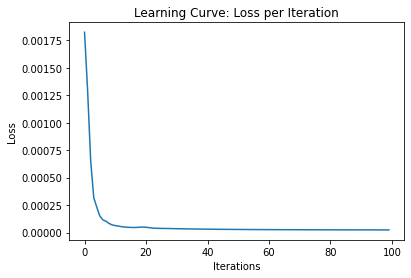

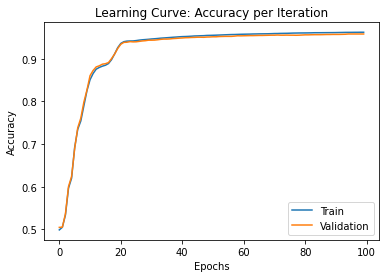

In [14]:
plot_learning_curve(learning_curve_info)

The current network, which consists of two layers with 30 hidden neurons, has achieved a test accuracy of 96% using Adam Optimizer and Cross Entropy Loss. This is considered to be a good result and there is no evidence of overfitting.

 The next step is to explore various cost functions, such as MSE, CrossEntropy, Negative Log Likelihood, and BCEWithLogitsLoss, in order to improve the performance of the network and compare the results.


 First, Lets define our grid search method

In [ ]:
from pickle import TRUE
from sklearn.model_selection import GridSearchCV
import itertools

def print_params(params_dict):
    ## Print the hyper paramters in readable way
    print("Cost Function: ", params_dict['cost'])
    print("Optimizer: ", params_dict['optimizer'])
    print("Learning Rate: ", params_dict['learning_rate'])
    print("Normalization: ", params_dict['normalization'])
    print("Dropout: ", params_dict['dropout'])
    print("Dropout Value: ", params_dict['dropout_value'])
    print("Weight Decay: ", params_dict['weight_decay'])
    print("Batch Size: ", params_dict['batch_size'])
    print("Number of Epochs: ", params_dict['epochs'])
    print("Size of Hidden Layers: ", params_dict['hidden_layers_size'])
    print("Amount of Hidden Layers: ", params_dict['hidden_layers'])
    print("Activation Function: ", params_dict['activation_function'])


def grid_search(train_data, validation_data, test_data, hyperparameters):
    #This Function Perform a grid search for the best hyper parameters for our model.
    # Create a list of all possible combinations of hyperparameters given a dictionary of hyperparameters
    combinations = list(itertools.product(*hyperparameters.values()))
    best_val_acc = 0
    best_hyperparameters = None
    file_to_save='/content/gdrive/MyDrive/Colab Notebooks/DNNPROJECT/gridSearch_1.csv'
    column_names = ['val_acc','cost','optimizer','lr','normal','dropout','dropout_val',\
                    'wd','batch','epoch','hidden_layers_size','hidden_layers','activation_function']
    pi = pd.DataFrame(columns=column_names)
    pi.to_csv(file_to_save, index=False)
    # Iterate through all combinations of hyperparameters
    i=0
    for combination in combinations:
        print("*"*20 )
        # Convert the combination tuple to a dictionary
        hypers = dict(zip(hyperparameters.keys(), combination))
        print_params(hypers)
        if torch.cuda.is_available():
          model = FirstBasicNN(num_hidden=hypers['hidden_layers_size'], activation=hypers['activation_function'], dropout=hypers['dropout'], 
            dropout_value=hypers['dropout_value'], norm=hypers['normalization'],
            number_of_layers=hypers['hidden_layers']).cuda()
        else:
          model = FirstBasicNN(num_hidden=hypers['hidden_layers_size'], activation=hypers['activation_function'], dropout=hypers['dropout'], 
            dropout_value=hypers['dropout_value'], norm=hypers['normalization'],
            number_of_layers=hypers['hidden_layers'])

        #Initlize all the weights
        model.weight_init(mean=0, std=0.02)
        # Train the model with the current combination of hyperparameters
        aranged_hypers = [hypers['cost'], hypers['optimizer'], hypers['learning_rate'], hypers['weight_decay'], hypers['epochs'], hypers['batch_size']]
        #Get only the validation accuracy as our score
        _, _, _, _, val_accs = train_model(model, train_data, validation_data, test_data, hypers=aranged_hypers)
        # Get the last validation accuracy from the training process
        val_acc = val_accs[-1]
        par = [val_acc,hypers['cost'],hypers['optimizer'],hypers['learning_rate'],\
               hypers['normalization'],hypers['dropout'],hypers['dropout_value'],\
               hypers['weight_decay'],hypers['batch_size'],hypers['epochs'],\
               hypers['hidden_layers_size'],hypers['hidden_layers'],hypers['activation_function']]
        pip = pd.DataFrame(columns=column_names)
        pip.loc[i]=par
        pip.to_csv(file_to_save, mode='a', header=False)
        # Update the best hyperparameters if the current combination results in a higher accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_hyperparameters = combination

    # Print the best hyperparameters and their corresponding validation accuracy
    print("Best hyperparameters:", best_hyperparameters)
    print("Best validation accuracy: %.2f%%" % (best_val_acc * 100))
    return best_hyperparameters


param_grid = {'cost': ['MSE', 'CE', 'BCEWithLogitsLoss'],
              'optimizer': ['SGD', 'RMS', 'ADAM', 'ADAMAX'],
              'learning_rate': [1e-5, 1e-4, 1e-3, 0.01, 0.1, 0.5],
              'normalization': ['LayerNorm', 'None'],
              'dropout': ['Dropout', 'None'],
              'dropout_value': [0.1, 0.2],
              'weight_decay': [0, 1e-8, 1e-5, 1e-3],
              'epochs': [50, 100, 150, 200],
              'hidden_layers_size': [10, 20, 30, 40, 50],
              'hidden_layers': [2, 3, 4, 5, 6, 7],
              'activation_function': ['ReLU', 'Sigmoid', 'Tanh'],
              'batch_size': [500, 1000, 5000]
              }
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

grid_search(train, valid, test, param_grid)


********************
Cost Function:  MSE
Optimizer:  SGD
Learning Rate:  1e-05
Normalization:  LayerNorm
Dropout:  Dropout
Dropout Value:  0.1
Weight Decay:  0
Batch Size:  500
Number of Epochs:  50
Size of Hidden Layers:  10
Amount of Hidden Layers:  2
Activation Function:  ReLU
NN Accuracy on Validation Set: 50.69%
NN Accuracy on Training Set: 50.38%
NN Accuracy on Test Set: 51.31%
********************
Cost Function:  MSE
Optimizer:  SGD
Learning Rate:  1e-05
Normalization:  LayerNorm
Dropout:  Dropout
Dropout Value:  0.1
Weight Decay:  0
Batch Size:  1000
Number of Epochs:  50
Size of Hidden Layers:  10
Amount of Hidden Layers:  2
Activation Function:  ReLU
NN Accuracy on Validation Set: 52.32%
NN Accuracy on Training Set: 51.32%
NN Accuracy on Test Set: 49.82%
********************
Cost Function:  MSE
Optimizer:  SGD
Learning Rate:  1e-05
Normalization:  LayerNorm
Dropout:  Dropout
Dropout Value:  0.1
Weight Decay:  0
Batch Size:  5000
Number of Epochs:  50
Size of Hidden Layers:  1